<a href="https://colab.research.google.com/github/praneethsai83/GenericProcessing/blob/main/models/UNet_Plus_Plus_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install import-ipynb

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 6.6 MB/s eta 0:00:00


In [ ]:
%cd '/content/drive/MyDrive/Colab Notebooks/'

/content/drive/MyDrive/Colab Notebooks


In [ ]:
import os
import numpy as np
from keras.preprocessing.image import load_img
from matplotlib import pyplot as plt
from tensorflow import keras
import random
import import_ipynb
from utilities import *

importing Jupyter notebook from utilities.ipynb


In [ ]:
train_img_fnames, train_mask_fnames, test_img_fnames, test_mask_fnames, pred_img_fnames = get_data_set_filenames()

Number of training images:  1000
Number of training masks:  1000
Number of testing images:  408
Number of testing masks:  408
Number of prediction images:  96


In [ ]:
batch_size = 8
img_size = (160, 160)

train_gen = ImageDataGenerator(batch_size, img_size, train_img_fnames, train_mask_fnames)
val_gen = ImageDataGenerator(batch_size, img_size, test_img_fnames, test_mask_fnames)

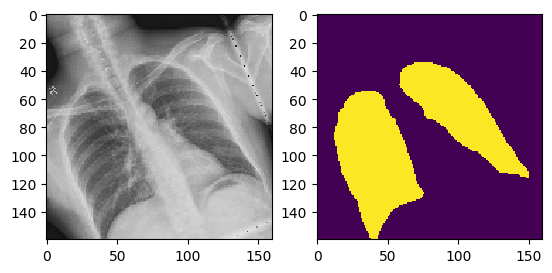

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.imshow(train_gen[0][0][1], interpolation='nearest')
ax2.imshow(train_gen[0][1][1], interpolation='nearest')
plt.show()

In [ ]:
import tensorflow as tf
from tensorflow import keras
from keras.layers import Input, Conv2D, MaxPooling2D, Activation, ReLU
from keras.layers import BatchNormalization, Conv2DTranspose, Concatenate, Average
from keras.models import Model, Sequential

UNet++ Model Definition

In [ ]:
def convolution_operation(entered_input, filters=64):
 # Taking first input and implementing the first conv block
 conv1 = Conv2D(filters, kernel_size = (3,3), padding = "same")(entered_input)
 batch_norm1 = BatchNormalization()(conv1)
 act1 = ReLU()(batch_norm1)

 # Taking first input and implementing the second conv block
 conv2 = Conv2D(filters, kernel_size = (3,3), padding = "same")(act1)
 batch_norm2 = BatchNormalization()(conv2)
 act2 = ReLU()(batch_norm2)

 return act2

def encoder(entered_input, filters=64):
 # Collect the start and end of each sub-block for normal pass and skip connections
 enc1 = convolution_operation(entered_input, filters)
 MaxPool1 = MaxPooling2D(strides = (2,2))(enc1)
 return enc1, MaxPool1

def decoder(entered_input, skips, filters=64):
 # Upsampling and concatenating the essential features
 Upsample = Conv2DTranspose(filters, (2, 2), strides=2, padding="same")(entered_input)
 Connect_Skip = Concatenate()([Upsample] + skips)
 out = convolution_operation(Connect_Skip, filters)
 return out


In [ ]:
def U_Net_plus_plus(Image_Size, deep_supervision=True):
 # Take the image size and shape
 input1 = Input(Image_Size)

 # Construct the encoder blocks
 x_00, encoder_1 = encoder(input1, 64)
 x_10, encoder_2 = encoder(encoder_1, 64*2)
 x_20, encoder_3 = encoder(encoder_2, 64*4)
 x_30, encoder_4 = encoder(encoder_3, 64*8)
 x_40 = convolution_operation(encoder_4, 64*16)

 # Construct the Nested decoder blocks
 x_01 = decoder(x_10, [x_00], 64)
 x_11 = decoder(x_20, [x_10], 64*2)
 x_21 = decoder(x_30, [x_20], 64*4)
 x_31 = decoder(x_40, [x_30], 64*8)

 x_02 = decoder(x_11, [x_00, x_01], 64)
 x_12 = decoder(x_21, [x_10, x_11], 64*2)
 x_22 = decoder(x_31, [x_20, x_21], 64*4)

 x_03 = decoder(x_12, [x_00, x_01, x_02], 64)
 x_13 = decoder(x_22, [x_10, x_11, x_12], 64*2)

 x_04 = decoder(x_13, [x_00, x_01, x_02, x_03], 64)

 if deep_supervision:
  out = [
      Conv2D(1, 1, padding="same", activation="sigmoid")(x_01),
      Conv2D(1, 1, padding="same", activation="sigmoid")(x_02),
      Conv2D(1, 1, padding="same", activation="sigmoid")(x_03),
      Conv2D(1, 1, padding="same", activation="sigmoid")(x_04)
  ]
  out = Average()(out)
  # out = Concatenate()(out)
 else:
  out = Conv2D(1, 1, padding="same", activation="sigmoid")(x_04)
  # out = [
  #     Conv2D(1, 1, padding="same", activation="sigmoid")(x_04)
  #     ]

 model = Model(input1, out)
 return model


In [ ]:
input_shape = (160, 160, 3)
model = U_Net_plus_plus(input_shape, deep_supervision=True)

In [ ]:
import keras.backend as K
def dice_coef(y_true, y_pred, smooth=100):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    dice = (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)
    return dice

In [ ]:
model.compile(optimizer="rmsprop", loss="binary_crossentropy", metrics=["accuracy", keras.metrics.MeanIoU(num_classes=2), dice_coef])

In [ ]:
callbacks = [
 keras.callbacks.ModelCheckpoint("/content/checkpoint/unet_plus_plus_model.keras", save_best_only=True)
]
# Train the model, doing validation at the end of each epoch.
epochs = 15
model.fit(train_gen, epochs=epochs, validation_data=val_gen, callbacks=callbacks)

Epoch 1/15
125/125 [==============================] - 330s 3s/step - loss: 0.2569 - accuracy: 0.8954 - mean_io_u_2: 0.3719 - dice_coef: 0.6971 - val_loss: 0.5515 - val_accuracy: 0.7879 - val_mean_io_u_2: 0.3727 - val_dice_coef: 0.3455
Epoch 2/15
125/125 [==============================] - 316s 3s/step - loss: 0.1211 - accuracy: 0.9597 - mean_io_u_2: 0.3719 - dice_coef: 0.8536 - val_loss: 0.2040 - val_accuracy: 0.9365 - val_mean_io_u_2: 0.3727 - val_dice_coef: 0.7823
Epoch 3/15
125/125 [==============================] - 316s 3s/step - loss: 0.0967 - accuracy: 0.9680 - mean_io_u_2: 0.3719 - dice_coef: 0.8838 - val_loss: 0.1226 - val_accuracy: 0.9597 - val_mean_io_u_2: 0.3727 - val_dice_coef: 0.8367
Epoch 4/15
125/125 [==============================] - 316s 3s/step - loss: 0.0783 - accuracy: 0.9739 - mean_io_u_2: 0.3719 - dice_coef: 0.9050 - val_loss: 0.2177 - val_accuracy: 0.8904 - val_mean_io_u_2: 0.3727 - val_dice_coef: 0.7118
Epoch 5/15
125/125 [==============================] - 316s 3

In [ ]:
%cp /content/checkpoint/unet_plus_plus_model.keras /content/drive/MyDrive/Model/unet_plus_plus_model_with_deep_supervision_avg_v2.keras

In [ ]:
# model.save("/content/drive/MyDrive/Model/unet_plus_plus_model_with_deep_supervision_avg_v1.keras", overwrite=True)